# 第 9 章 策略梯度算法--log

本书之前介绍的 Q-learning、DQN 及 DQN 改进算法都是**基于价值（value-based）的方法**，
其中 Q-learning 是处理有限状态的算法，而 DQN 可以用来解决连续状态的问题。

在强化学习中，除了基于值函数的方法，还有一支非常经典的方法，那就是**基于策略（policy-based）的方法**。

对比两者:
- 基于值函数的方法主要是学习值函数，然后根据值函数导出一个策略，学习过程中并不存在一个显式的策略；
- 基于策略的方法则是直接显式地学习一个目标策略。策略梯度是基于策略的方法的基础，本章从策略梯度算法说起。

## 策略梯度

基于策略的方法首先需要将策略参数化。假设目标策略$π_θ$是一个随机性策略，并且处处可微，其中θ是对应的参数。我们可以用一个线性模型或者神经网络模型来为这样一个策略函数建模：输入某个状态，然后输出一个动作的概率分布。

我们的目标是要寻找一个最优策略并最大化这个策略在环境中的期望回报。

我们将策略学习的目标函数定义为
$J(θ) = E_{s_0}[V^{π_θ}{(s_0)}]$

$s_0$表示初始状态。

**现在有了目标函数，我们将目标函数对策略θ求导，得到导数后，就可以用梯度上升方法来最大化这个目标函数，从而得到最优策略。**

我第 3 章讲解过策略π下的状态访问分布，在此用$V^π$表示。然后我们对目标函数求梯度，可以得到如下式子，更详细的推导过程将在 9.6 节给出

In [3]:
from IPython.display import Image


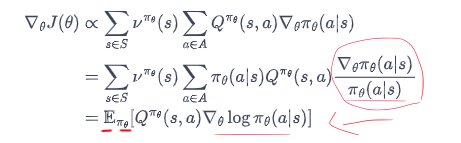

In [4]:
Image(filename="./target.png")

这个梯度可以用来更新策略。需要注意的是，因为上式中期望E的下标是$π_θ$，所以策略梯度算法为在线策略（on-policy）算法，即必须使用当前策略$π_θ$采样得到的数据来计算梯度。

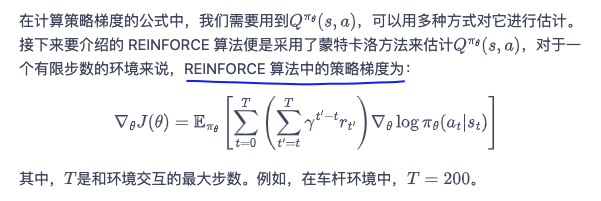

In [4]:
Image(filename="./reinforce.png")

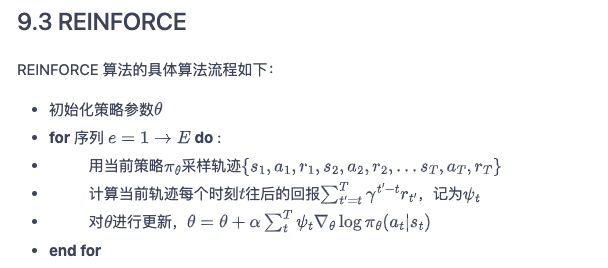

In [5]:
Image(filename="./rein_step.png")

In [20]:
# REINFORCE 代码实践
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

In [7]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    # 其输入是某个状态，输出则是该状态下的动作概率分布
    def forward(self, x):
        x = F.relu(self.fc1(x))
        # 这里采用在离散动作空间上的softmax()函数来实现一个可学习的多项分布
        return F.softmax(self.fc2(x), dim=1)

In [14]:
'''定义REINFORCE算法'''
class REINFORCE:
    def __init__(self,state_dim,hidden_dim,action_dim,learning_rate,gamma,device):
        self.policy_net = PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.device = device
        
    def take_action(self,state):# 根据动作概率分布随机采样
        state = torch.tensor([state],dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    def update(self,transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['action']
        
        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))): # 从后向前计算
            reward = reward_list[i]
            state = torch.tensor([state_list[i]],dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1,1).to(self.device)
            
            log_prob = torch.log(self.policy_net(state).gather(1,action))
            G = reward + self.gamma * G
            
            loss = -log_prob * G # 每一步的损失函数
            loss.backward() #反向传播计算梯度
        self.optimizer.step() # 梯度下降
        

In [21]:
# 看看REINFORCE算法在车杆环境上表现如何
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

env_name = "CartPole-v1"
env = gym.make(env_name)
# env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim,hidden_dim,action_dim,learning_rate,gamma,device)

return_list = []

for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            
            state = env.reset()
            done = False
            while not done:
                
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                #更新
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':'%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':'%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 0:   0%|                                      | 0/100 [00:00<?, ?it/s]


ValueError: expected sequence of length 4 at dim 2 (got 0)

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

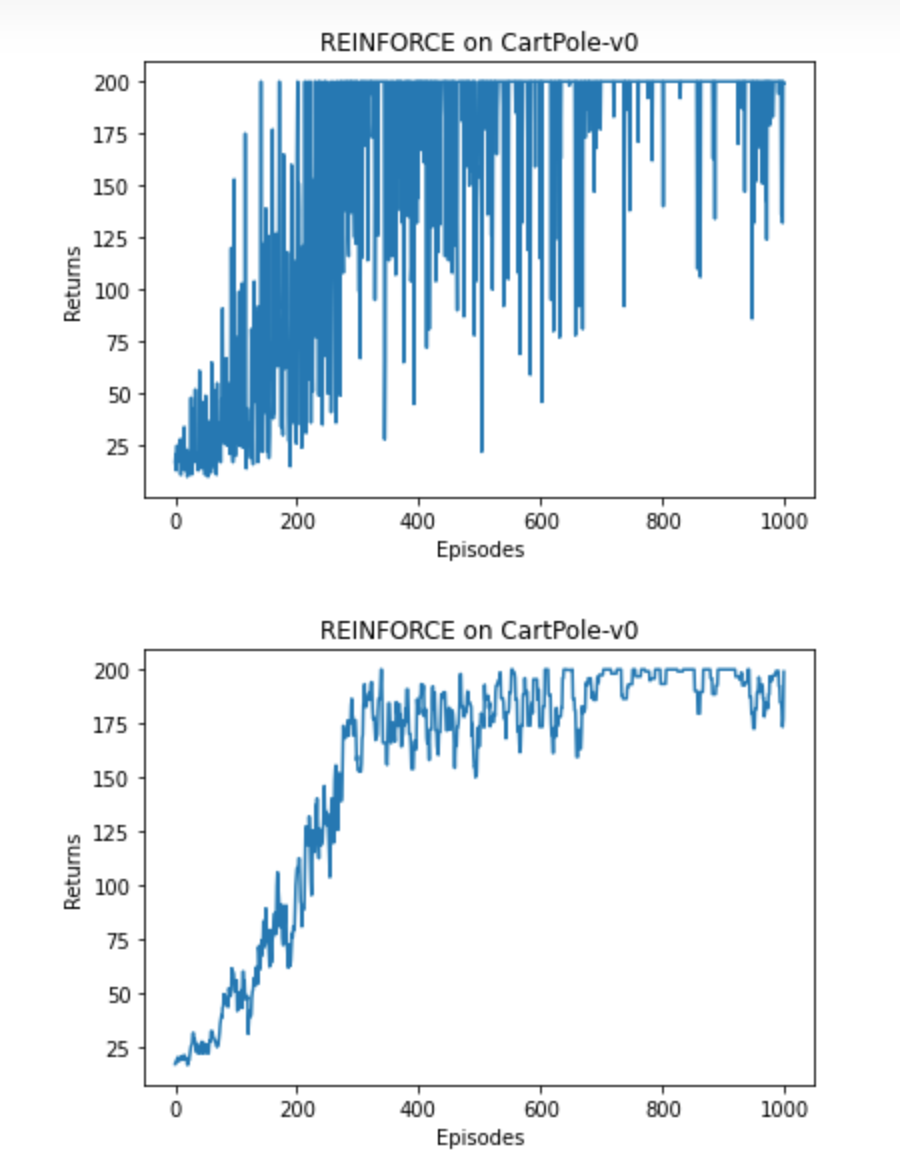

In [22]:
Image(filename='./re-line.png')

可以看到，随着收集到的轨迹越来越多，REINFORCE 算法有效地学习到了最优策略。

不过，相比于前面的 DQN 算法，REINFORCE 算法使用了更多的序列，这是因为 REINFORCE 算法是一个在线策略算法，之前收集到的轨迹数据不会被再次利用。

此外，REINFORCE 算法的性能也有一定程度的波动，这主要是因为每条采样轨迹的回报值波动比较大，这也是 REINFORCE 算法主要的不足。

REINFORCE 算法是策略梯度乃至强化学习的典型代表，智能体根据当前策略直接和环境交互，通过采样得到的轨迹数据直接计算出策略参数的梯度，进而更新当前策略，使其向最大化策略期望回报的目标靠近。这种学习方式是典型的从交互中学习，并且其优化的目标（即策略期望回报）正是最终所使用策略的性能，这比基于价值的强化学习算法的优化目标（一般是时序差分误差的最小化）要更加直接。

REINFORCE 算法理论上是能保证局部最优的，它实际上是借助蒙特卡洛方法采样轨迹来估计动作价值，这种做法的一大优点是可以得到无偏的梯度。但是，正是因为使用了蒙特卡洛方法，REINFORCE 算法的梯度估计的方差很大，可能会造成一定程度上的不稳定，

这也是第 10 章将介绍的 Actor-Critic 算法要解决的问题。

#  策略梯度证明